<h4>Part I: Research Question</h4>
<p><b>A1. </b>Can we create and train a neural network model using NLP techniques to analyze the history of customers reviews and scores to forecast and predict customer sentiment is positive or negative?<p>
<p><b>A2. </b>This study aims to prepare the history of customer reviews and scores and build and train the neural network model to predict and forecast customer sentiment and define positive or negative to understand the customer and improve the business by supporting the marketing process.
<p><b>A3. </b>The study will use the TensorFlow Neural Networks, the sentiment analysis is one of the tasks in Natural Language Processing (NLP) techniques that will perform a text classification that can be trained to predict text sequences.

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7552959.svg)](https://doi.org/10.5281/zenodo.7552959)
<br/>

<h4>Part II: Data Preparation</h4>
<p><b>B.</b> The data preparation process

In [89]:
import pandas as pd
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dateutil.parser import parse
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
import string
import re
import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [3]:
# Convert and load the gz file to DataFrame

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
    #if i == 1000 : break  # to run for first 1000 just for the quick test
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Amazon_Instant_Video.json.gz')

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1EE2E3N7PW666,B000GFDAUG,"Aaron L. Allen ""Orgazmo1009""","[0, 0]",CA Lewsi' review should be removed. he's revie...,5.0,Stupid,1202256000,"02 6, 2008"
1,AGZ8SM1BGK3CK,B000GFDAUG,Mind's Clay,"[1, 1]",I truly love the humor of South Park. It's soc...,5.0,"""More Moist Than Should Be"" Humor",1198195200,"12 21, 2007"
2,A2VHZ21245KBT7,B000GIOPK2,"202_d ""202_d""","[0, 0]",This is a cartoon series pitting eight cartoon...,4.0,"Overall, really like the series.",1215388800,"07 7, 2008"
3,ACX8YW2D5EGP6,B000GIOPK2,"Alexandra Stephens ""dreamgirl0922""","[11, 13]",Yeah drawn together is great when it comes to ...,4.0,Crude cartoon humor...Check,1185840000,"07 31, 2007"
4,A9RNMO9MUSMTJ,B000GIOPK2,Andre Villemaire,"[0, 2]",Seems like today's generation is getting reven...,2.0,not bad...,1281052800,"08 6, 2010"


In [4]:
df.describe()

,overall,unixReviewTime
count,583933.000000,5.839330e+05
mean,4.316185,1.377140e+09
std,1.163706,3.257195e+07
min,1.000000,9.354528e+08
25%,4.000000,1.368835e+09
50%,5.000000,1.387325e+09
75%,5.000000,1.394669e+09
max,5.000000,1.406074e+09


In [16]:
#Remove nulls
df = df.dropna()

Eng_stopwords = nltk.corpus.stopwords.words('english')

df_selected = pd.DataFrame()
df_selected['Score'] = df['overall']

# replacing our Non-English characters by space
df_selected['reviewText'] = df['reviewText'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# split in words
df_selected['Review_in_words'] = df['reviewText'].apply(lambda x: re.split('\W+', x))

# Avoid the stop words and convert all words to lower case.
df_selected['Nostop_words'] = \
    df_selected['Review_in_words'].apply(lambda x: [word.lower() for word in x if word not in Eng_stopwords])

# classifying the score to positive Sentiment if score 5, 4 or 3.
df_selected['Sentiment'] = df['overall'].apply(lambda x: 1 if x in [3, 4, 5] else 0)

df_selected.head(10)    

,Score,reviewText,Review_in_words,Nostop_words,Sentiment
0,5.0,CA Lewsi review should be removed he s revie...,"[CA, Lewsi, review, should, be, removed, he, s...","[ca, lewsi, review, removed, reviewing, episod...",1
1,5.0,I truly love the humor of South Park It s soc...,"[I, truly, love, the, humor, of, South, Park, ...","[i, truly, love, humor, south, park, it, socia...",1
2,4.0,This is a cartoon series pitting eight cartoon...,"[This, is, a, cartoon, series, pitting, eight,...","[this, cartoon, series, pitting, eight, cartoo...",1
3,4.0,Yeah drawn together is great when it comes to ...,"[Yeah, drawn, together, is, great, when, it, c...","[yeah, drawn, together, great, comes, crude, h...",1
4,2.0,Seems like today s generation is getting reven...,"[Seems, like, today, s, generation, is, gettin...","[seems, like, today, generation, getting, reve...",0
5,5.0,I dont agree with the reviewer who says the sh...,"[I, dont, agree, with, the, reviewer, who, say...","[i, dont, agree, reviewer, says, show, wears, ...",1
6,5.0,Apparently I m one of the few who really think...,"[Apparently, I, m, one, of, the, few, who, rea...","[apparently, i, one, really, thinks, drawn, to...",1
7,4.0,I liked this product I am a big fan of Drawn ...,"[I, liked, this, product, I, am, a, big, fan, ...","[i, liked, product, i, big, fan, drawn, togeth...",1
8,5.0,the show it is really funny it is a good sho...,"[the, show, it, is, really, funny, it, is, a, ...","[show, really, funny, good, show, get, dvd, i,...",1
9,5.0,People who like cartoons must be thankful for ...,"[People, who, like, cartoons, must, be, thankf...","[people, like, cartoons, must, thankful, dvds,...",1


In [17]:
# count words per review
df_selected['num_words'] = df_selected['Nostop_words'].apply(lambda x: len(x))

# join words to be statement
df_selected['words'] = df_selected['Nostop_words'].apply(lambda x: ' '.join(x))

df_selected.describe()

,Score,Sentiment,num_words
count,578419.000000,578419.000000,578419.000000
mean,4.316831,0.897011,32.205944
std,1.162447,0.303945,46.725136
min,1.000000,0.000000,0.000000
25%,4.000000,1.000000,15.000000
50%,5.000000,1.000000,19.000000
75%,5.000000,1.000000,32.000000
max,5.000000,1.000000,3252.000000


In [7]:
max_num_words = df_selected['num_words'].values.max()
print('Max Number of words: ', max_num_words)

Max Number of words:  3252


In [52]:
# Set parameters for vocabulary, tokenizer, Pad sentences and the model

# maximum number of unique words used in our model
vocab_size = 60000 

# Embedded words into 16 dimensions
embedding_dim = 16

# Maximum length per review
max_length = 100

# "post"-truncated after 100 to the end of the review
trunc_type = 'post'

# "Out of Vocabulary" (OOV) to replace any unknown words
oov_tok = '<OOV>'

# if review less than 100 padding applied until the end of the review
padding_type = 'post'
# Instantiate tokenizer object
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

# Fit tokenizer to training set
tokenizer.fit_on_texts(df_selected['words'])
word_index = tokenizer.word_index

# Pad sentences
sequences = tokenizer.texts_to_sequences(df_selected['words'])
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

<h4>Tokenization</h4>
<p>Tokenization is a key aspect of working with text data and is a common task in Natural Language Processing (NLP).
Tokenization is separating a piece of text into smaller units called tokens. Tokens can be either word, characters, or sub-words. Hence, tokenization can be broadly classified into three types word, characters, or sub-words. (Analytics Vidhya. 2022)
    
<h4>Padding process</h4>
<p>To prepare the data for the NLP model, the padding process standardizes the lengths of the sentences by adding pads at the beginning or end of each sentence to be in the same length, in our code using the ‘Post’ option to add the pads at the end of a sentence.

<h4>Sentiment Categories</h4>
<p>Simplified the categories of Sentiment in just two types (1 mean positive Sentiment verified by the scores (3, 4, or 5) and 0 mean negative sentiment verified by the scores (1, or 2). 
    
    

In [53]:
vocabulary_counter = str(len(word_index))
print('The vocabularies count: ' +  vocabulary_counter)

print('\nExample for padded sequence:\n\n\t\"' + str(df_selected['words'][10]) + '\"\n\n')

print(str(padded[10]))

The vocabularies count: 163860

Example for padded sequence:

	"very adult humor cutting sarcasm dry take reality shows least "


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  122  643  186 2745 4327 1659  159  288
   30  237]


In [54]:
# drop the extra and useless columns.
df_clean = df_selected.drop(['Review_in_words', 'Nostop_words', 'num_words', 'reviewText'], axis = 1)

# Save copy of Cleaned dataset
df_clean.to_csv('prepared_clean_dataset.csv')

In [55]:
#Split data to 80% training Data and 20% test data
X_train, X_test, y_train, y_test = \
train_test_split(padded, df_selected['Sentiment'], test_size=0.20, random_state=100)


<h4>Part III:  Network Architecture</h4>
<p>The Network used TensorFlow to create Keras model with the following Sequential:
<ol>
    <li>Embedding layer to defines the parameters like vocabulary size, dimension, and maximum length for the input and the results will be 960000 parameters
    <li>GlobalAveragePooling1D layer to convert the vector to one dimension and the results will be no parameters
    <li>Hidden layer applies the “relu” a rectified linear activation function and has 20 density and the results will be 340 parameters.
    <li>Hidden layer applies the “relu” a rectified linear activation function and has 10 density and the results will be 210 parameters.
    <li>Output and final layer apply the “relu” a rectified linear activation function and have 1 density and the results will be 11 parameters.
</ol>


In [63]:
# Create the model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), # Embedding layer where parameters are defined
    tf.keras.layers.GlobalAveragePooling1D(), # Convert vector to one dimension
    tf.keras.layers.Dense(20, activation = 'relu'), # Hidden layer
    tf.keras.layers.Dense(10, activation = 'relu'), # Hidden layer
    tf.keras.layers.Dense(1, activation = 'relu') # Output Layer 
])

In [64]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [93]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 16)           960000    
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_24 (Dense)            (None, 20)                340       
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 960,561
Trainable params: 960,561
Non-trainable params: 0
________________________________________________

In [66]:
# number of epochs
num_epochs = 20

# Fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs = num_epochs,
                    callbacks = EarlyStopping(monitor = 'val_loss'), 
                    validation_data = (X_test, y_test))

Epoch 1/20
14461/14461 [==============================] - 136s 9ms/step - loss: 0.2477 - accuracy: 0.9050 - val_loss: 0.2325 - val_accuracy: 0.9335
Epoch 2/20
14461/14461 [==============================] - 140s 10ms/step - loss: 0.1934 - accuracy: 0.9374 - val_loss: 0.1939 - val_accuracy: 0.9400


In [67]:
# Fit model tuning by extra parameters: 
history = model.fit(X_train, 
                    y_train, 
                    epochs = num_epochs,
                    callbacks = EarlyStopping(monitor = 'val_loss', 
                                              mode ="min", 
                                              patience = 5, 
                                              restore_best_weights = True), 
                    batch_size=64,
                    validation_data = (X_test, y_test))

Epoch 1/20
7231/7231 [==============================] - 72s 10ms/step - loss: 0.1892 - accuracy: 0.9269 - val_loss: 0.1862 - val_accuracy: 0.9399
Epoch 2/20
7231/7231 [==============================] - 68s 9ms/step - loss: 0.1832 - accuracy: 0.9373 - val_loss: 0.1910 - val_accuracy: 0.9409
Epoch 3/20
7231/7231 [==============================] - 69s 10ms/step - loss: 0.1592 - accuracy: 0.9478 - val_loss: 0.1914 - val_accuracy: 0.9403
Epoch 4/20
7231/7231 [==============================] - 69s 10ms/step - loss: 0.1579 - accuracy: 0.9465 - val_loss: 0.2128 - val_accuracy: 0.9399
Epoch 5/20
7231/7231 [==============================] - 69s 10ms/step - loss: 0.1622 - accuracy: 0.9473 - val_loss: 0.2180 - val_accuracy: 0.9407
Epoch 6/20
7231/7231 [==============================] - 70s 10ms/step - loss: 0.1789 - accuracy: 0.9377 - val_loss: 0.2462 - val_accuracy: 0.9403


<h4>Justify Hyperparameters</h4>
<p>The Network used TensorFlow to create Keras model with the following Sequential:
<ul>
    <li>Activation Function: use the “relu” a rectified linear activation function for the two hidden layers, which is commonly used in most of the Networks because easy in the train and has better performance.
    <li>Number of nodes per layer: during practice multiple tests and because the dataset has 578419 rows, I found the best accuracy around 95% comes with 20, 10 densities for hidden layers.
    <li>Loss function: apply 'binary_crossentropy' which is perfect for the binary classification problems.
    <li>Optimizer: “Adam” which uses little memory and is suited for large problems.
    <li>Stopping Criteria: “EarlyStopping” which stops the training if the performance going to degrade per Epoch, avoiding overdraft.
    <li>Evaluation Metric: “Accuracy” is used in evaluating the model comparing the accuracy of the results.
</ul>

<h4>Part IV:  Model Evaluation</h4>

<b>stopping criteria:</b>
<p>Its callback function during the model fitting to measure the improvement changes per epoch to not continue if the loss degrades to avoid running the rest of epochs. The stopping criteria function used in the study is “EarlyStopping” which stops running the rest of the epoch in the first try after the second epoch and in the second try in epoch 6.</p>
    
    
<b>Fitness of the model:</b>
<p>For the best fit and avoid overfitting the study used the EarlyStopping callback function as Stopping criteria which stopped with epoch 6 as the optimal number of epochs.</p>
    
    
<b>Predictive Accuracy:</b>    
<p>Using the model evaluation function, the training data accuracy results are around 95 % which reflects confidence in the model accuracy.</p>

In [122]:
# Evaluate the model

loss, accuracy = model.evaluate(X_train, y_train)
print('\nAccuracy: %f' % (accuracy * 100))

14461/14461 [==============================] - 12s 848us/step - loss: 0.1546 - accuracy: 0.9460

Accuracy: 94.601661


<Figure size 432x288 with 0 Axes>

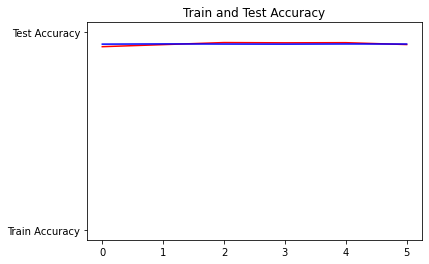

<Figure size 432x288 with 0 Axes>

In [87]:
# visualizations of the model’s training process

epochs=range(len(history.history['accuracy']))

plt.plot(epochs, history.history['accuracy'], 'r', 'Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', 'Test Accuracy')
plt.title('Train and Test Accuracy')
plt.figure()

<Figure size 432x288 with 0 Axes>

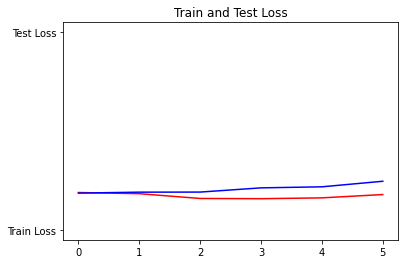

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot(epochs, history.history['loss'], 'r', 'Train Loss')
plt.plot(epochs, history.history['val_loss'], 'b', 'Test Loss')
plt.title('Train and Test Loss')
plt.figure()

<h4>Part V:  Summary and Recommendations</h4>

<b>Functionality:</b>

<p>The study creates and trains a neural network to understand the customer review text to predict Sentiment, classifying positive or negative sentiment based on the words coming in the customer review text. Built the neural network model by sequential of five layers includes two hidden layers compile with “Binary Crossentropy” loss function optimizes by “Adam” evaluated by “accuracy” metrics and fitted by separated training data and validated by testing data. </p>

<b>Recommendedations:</b> 
    
<p>The decision-makers could use the study to understand the customer’s sentiments and predict the customer’s sentiments and classify and filter the customer’s review in the form which could support the marketing activities and improve the customer’s satisfaction.
<p>
The study accuracy results around 95% which reflects confidence in the model accuracy and the data analyst could run more tests on more data to improve the model results.


In [91]:
# Save the model in HDF5 file
model.save('SENTIMENT_model_20220120.h5')

<b>Acknowledge Sources:</b>
<p>Analytics Vidhya. (2022, Jan. 19) Time Series Analysis. [Web Site].  Retrieved from <a href="https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/">https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/</a>

<p>DataCamp (2022, Jan. 19) Sentiment Analysis Nuts and Bolts. [Web Site].  Retrieved from <a href="https://campus.datacamp.com/courses/sentiment-analysis-in-python/sentiment-analysis-nuts-and-bolts?ex=1">https://campus.datacamp.com/courses/sentiment-analysis-in-python/sentiment-analysis-nuts-and-bolts?ex=1</a>

<p>keras. (2022, Jan. 19) Text classification from scratch. [Web Site].  Retrieved from <a href="https://keras.io/examples/nlp/text_classification_from_scratch/">https://keras.io/examples/nlp/text_classification_from_scratch/</a>

<p>Towards. (2022, Jan. 19) Various Optimization Algorithms For Training Neural Network. [Web Site].  Retrieved from <a href="https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6">https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6</a>    

<b>Web Sources:</b>
    
<p>kavita. (2022, Jan. 18) How to Use Tfidftransformer & Tfidfvectorizer. [Web Site].  Retrieved from <a href="https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YeZZjf7MKUk">https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YeZZjf7MKUk</a>
        